In [4]:
library(h2o)
h2o.init(nthreads=-1)
if (!h2o.deepwater_available()) return()

Loading required package: statmod

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 51 minutes 
    H2O cluster version:        3.11.0.99999 
    H2O cluster version age:    21 hours and 23 minutes  
    H2O cluster name:           arno 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   13.57 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 



ERROR: Error in eval(expr, envir, enclos): could not find function "h2o.deepwater_available"


## Data Ingest
#### Image dataset
For simplicity, H2O Deep Water allows you to specify a list of URIs (file paths) or URLs (links) to images, together with a response column (either a class membership (enum) or regression target (numeric)).

For this example, we use this simple cat/dog/mouse dataset that has a few hundred images, and a label of cardinality 3.

In [15]:
df <- h2o.importFile("/home/arno/h2o-3/bigdata/laptop/deepwater/imagenet/cat_dog_mouse.csv")
print(head(df))
path = 1 ## must be the first column
response = 2

  |======================================================================| 100%
                                                               C1  C2
1  bigdata/laptop/deepwater/imagenet/cat/102194502_49f003abd9.jpg cat
2   bigdata/laptop/deepwater/imagenet/cat/11146807_00a5f35255.jpg cat
3 bigdata/laptop/deepwater/imagenet/cat/1140846215_70e326f868.jpg cat
4  bigdata/laptop/deepwater/imagenet/cat/114170569_6cbdf4bbdb.jpg cat
5 bigdata/laptop/deepwater/imagenet/cat/1217664848_de4c7fc296.jpg cat
6 bigdata/laptop/deepwater/imagenet/cat/1241603780_5e8c8f1ced.jpg cat


Let's look at a random subset of 10 images

Now, we build a classic convolutional neural network, called [LeNet](http://yann.lecun.com/exdb/lenet/)
![LeNet](images/lenet.gif)
![LeNet](images/lenet.jpg)

We'll use a GPU to train such a LeNet model in seconds

To build a LeNet image classification model in H2O, simply specify network = "lenet":

In [18]:
model <- h2o.deepwater(x=path, y=response, 
                       training_frame=df, epochs=50, 
                       learning_rate=1e-3, network = "lenet")
model

  |======================================================================| 100%


Model Details:

H2OMultinomialModel: deepwater
Model ID:  DeepWater_model_R_1477286246751_11 
Status of Deep Learning Model: lenet, 1.6 MB, predicting C2, 3-class classification, 14,336 training samples, mini-batch size 32
  input_neurons     rate momentum
1          2352 0.000986 0.990000


H2OMultinomialMetrics: deepwater
** Reported on training data. **
** Metrics reported on full training frame **

Training Set Metrics: 

Extract training frame with `h2o.getFrame("cat_dog_mouse.hex_sid_8d65_2")`
MSE: (Extract with `h2o.mse`) 0.1528063
RMSE: (Extract with `h2o.rmse`) 0.3909044
Logloss: (Extract with `h2o.logloss`) 0.4724447
Mean Per-Class Error: 0.1418395
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,train = TRUE)`)
Confusion Matrix: vertical: actual; across: predicted
       cat dog mouse  Error       Rate
cat     68   9    13 0.2444 =  22 / 90
dog      0  77     8 0.0941 =   8 / 85
mouse    3   5    84 0.0870 =   8 / 92
Totals  71  91   105 0.1423 = 38 / 267

Hit Rat

If you'd like to build your own LeNet network architecture, then this is easy as well.
In this example script, we are using the 'mxnet' backend. Models can easily be imported/exported between H2O and MXNet since H2O uses MXNet's format for model definition.

In [19]:
get_symbol <- function(num_classes = 1000) {
  library(mxnet)
  data <- mx.symbol.Variable('data')
  # first conv
  conv1 <- mx.symbol.Convolution(data = data, kernel = c(5, 5), num_filter = 20)

  tanh1 <- mx.symbol.Activation(data = conv1, act_type = "tanh")
  pool1 <- mx.symbol.Pooling(data = tanh1, pool_type = "max", kernel = c(2, 2), stride = c(2, 2))

  # second conv
  conv2 <- mx.symbol.Convolution(data = pool1, kernel = c(5, 5), num_filter = 50)
  tanh2 <- mx.symbol.Activation(data = conv2, act_type = "tanh")
  pool2 <- mx.symbol.Pooling(data = tanh2, pool_type = "max", kernel = c(2, 2), stride = c(2, 2))
  # first fullc
  flatten <- mx.symbol.Flatten(data = pool2)
  fc1 <- mx.symbol.FullyConnected(data = flatten, num_hidden = 500)
  tanh3 <- mx.symbol.Activation(data = fc1, act_type = "tanh")
  # second fullc
  fc2 <- mx.symbol.FullyConnected(data = tanh3, num_hidden = num_classes)
  # loss
  lenet <- mx.symbol.SoftmaxOutput(data = fc2, name = 'softmax')
  return(lenet)
}

In [ ]:
nclasses = nlevels(df[,response])
network <- get_symbol(nclasses)
cat(network$as.json(), file = "symbol_lenet-R.json", sep = '')

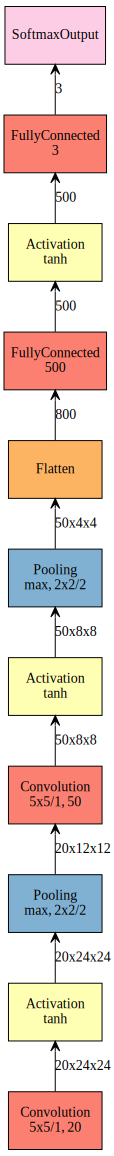

In [23]:
# sudo apt-get install graphviz
graph.viz(network$as.json())

In [35]:
model = h2o.deepwater(x=path, y=response, training_frame = df,
                      epochs=500, ## early stopping is on by default and might trigger before
                      network_definition_file="/tmp/symbol_lenet-R.json",  ## specify the model
                      image_shape=c(28,28),                                ## provide expected (or matching) image size
                      channels=3)                                          ## 3 for color, 1 for monochrome

  |======================================================================| 100%


In [36]:
summary(model)

Model Details:

H2OMultinomialModel: deepwater
Model Key:  DeepWater_model_R_1477286246751_19 
Status of Deep Learning Model: user, 1.6 MB, predicting C2, 3-class classification, 134,144 training samples, mini-batch size 32
  input_neurons     rate momentum
1          2352 0.004409 0.990000

H2OMultinomialMetrics: deepwater
** Reported on training data. **
** Metrics reported on full training frame **

Training Set Metrics: 

Extract training frame with `h2o.getFrame("cat_dog_mouse.hex_sid_8d65_2")`
MSE: (Extract with `h2o.mse`) 2.377149e-06
RMSE: (Extract with `h2o.rmse`) 0.001541801
Logloss: (Extract with `h2o.logloss`) 0.0007533561
Mean Per-Class Error: 0
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,train = TRUE)`)
Confusion Matrix: vertical: actual; across: predicted
       cat dog mouse  Error      Rate
cat     90   0     0 0.0000 =  0 / 90
dog      0  85     0 0.0000 =  0 / 85
mouse    0   0    92 0.0000 =  0 / 92
Totals  90  85    92 0.0000 = 0 / 267

Hit Ratio Ta

To see how much slower training a convolutional neural net is trained without a GPU, disable the 'gpu' flag. Note that using MKL or other optimized implementations of BLAS can make this difference shrink a lot, but generally a GPU is at least 5x faster than the best CPU implementations for realistic workloads, and often 50x faster or even more.

Instead of training for 500 epochs on the GPU, we'll train for 10 epochs on the CPU.

In [37]:
model = h2o.deepwater(x=path, y=response, training_frame = df,
                      epochs=10,
                      network_definition_file="/tmp/symbol_lenet-R.json",
                      image_shape=c(28,28),
                      channels=3,
                      gpu=FALSE)                                 

  |======================================================================| 100%


In [38]:
summary(model)

Model Details:

H2OMultinomialModel: deepwater
Model Key:  DeepWater_model_R_1477286246751_20 
Status of Deep Learning Model: user, 1.6 MB, predicting C2, 3-class classification, 3,072 training samples, mini-batch size 32
  input_neurons     rate momentum
1          2352 0.004985 0.927648

H2OMultinomialMetrics: deepwater
** Reported on training data. **
** Metrics reported on full training frame **

Training Set Metrics: 

Extract training frame with `h2o.getFrame("cat_dog_mouse.hex_sid_8d65_2")`
MSE: (Extract with `h2o.mse`) 0.3368704
RMSE: (Extract with `h2o.rmse`) 0.5804054
Logloss: (Extract with `h2o.logloss`) 0.8992756
Mean Per-Class Error: 0.4280998
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,train = TRUE)`)
Confusion Matrix: vertical: actual; across: predicted
       cat dog mouse  Error        Rate
cat     47  11    32 0.4778 =   43 / 90
dog     20  34    31 0.6000 =   51 / 85
mouse   12   7    73 0.2065 =   19 / 92
Totals  79  52   136 0.4232 = 113 / 267

Hit 